<a href="https://colab.research.google.com/github/ravindrabharathi/Project1/blob/master/session10/Grad-CAM-visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Section 1 : Grad_CAM visualization to 'find' / highlight sunglasses in an image 

### **Import Libraries and modules**

In [0]:
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Add, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils



Using TensorFlow backend.


# GRADCAM

Let's start with a pretrained VGG model

In [0]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import numpy as np
import cv2

1.  Loading helper functions
2.  Load VGG
3. Load Image
4. Rescale image to 224x224x3 (VGG's expectation, why?)
5. Use expand_dims to convert image to a batch of size 1
6. Preprocesing normalizes our input image by subtracting mean RGB values

In [0]:
model = VGG16(weights="imagenet")
from skimage import io
dog = io.imread("https://www.rspcapetinsurance.org.au/rspca/media/images/hero/dog-insurance-hero.jpg")
dog = cv2.resize(dog, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
x = image.img_to_array(dog)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

W0713 00:41:37.951457 139626272626560 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0713 00:41:37.970675 139626272626560 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0713 00:41:37.973652 139626272626560 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0713 00:41:37.999587 139626272626560 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0713 00:41:39.674464 139626272626560 deprecation_wrapp

Print model summary in order to choose the last 3 layers 

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

1. We get the predictions for the image
2. We take the topmost class index
3. Take output from the final convolutional layer, the layer before last layer and two layers before last layer 
4. Add these layers to layers list 

In [0]:
preds = model.predict(x)
class_idx = np.argmax(preds[0])
print(class_idx)
class_output = model.output[:, class_idx]

#get the final convolutional layer, the layer before last layer and two layers before last layer
last_conv_layer = model.get_layer("block5_conv3")
one_layer_before_last=model.get_layer("block5_conv2")
two_layers_before_last=model.get_layer("block5_conv1")


#add these layers to a list 
layers_list=[two_layers_before_last,one_layer_before_last,last_conv_layer]

180


### For each layer :
1. Compute the gradient of the class output value with respect to the feature map
2. Pool the gradients over all the axies leaving out the channel dimension
3. Weigh the output feature map with the computed gradient values

4. Average the weighted feature map along the channel dimension resulting in a heat map of size 14x14
5. Normalize the heat map to make the values between 0 and 1
6. Print the resulting heatmaps overlaid on original image 

Original Image :
---------------------------------



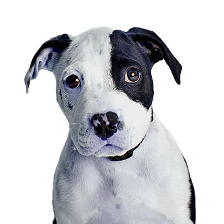



-------------------------------------------
GRADCAM Heat Map for Layer block5_conv1: 
-------------------------------------------



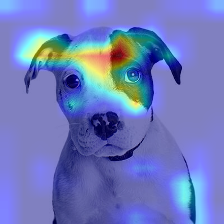



-------------------------------------------
GRADCAM Heat Map for Layer block5_conv2: 
-------------------------------------------



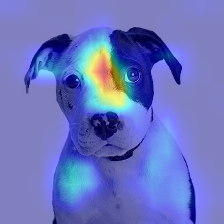



-------------------------------------------
GRADCAM Heat Map for Layer block5_conv3: 
-------------------------------------------



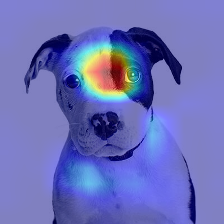

In [0]:
import keras.backend as K
from google.colab.patches import cv2_imshow

print("Original Image :\n---------------------------------\n")
cv2_imshow(dog)

for laiyer in layers_list:
  grads = K.gradients(class_output, laiyer.output)[0]
  #print(grads.shape)
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  #print(pooled_grads.shape)
  iterate = K.function([model.input], [pooled_grads, laiyer.output[0]])

  pooled_grads_value, conv_layer_output_value = iterate([x])

  for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
    
  #Average the weighted feature map along the channel dimension resulting in a heat map of size 14x14  
  heatmap = np.mean(conv_layer_output_value, axis = -1)
  #print(conv_layer_output_value.shape)
  #print(heatmap.shape)
  
  
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  heatmap = cv2.resize(heatmap, (dog.shape[1], dog.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(dog, 0.5, heatmap, 0.5, 0)
  print("\n\n-------------------------------------------\nGRADCAM Heat Map for Layer "+laiyer.name+": \n-------------------------------------------\n")
  
  cv2_imshow(superimposed_img)  
    

### Now we will use GRADCAM visualization to 'find' the sunglasses in this image 

![Tony Stark ](https://media.karousell.com/media/photos/products/2018/08/20/16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg)



1. Read the image 
2. Resize it to 224x 224 
3. preprocess the image 

In [0]:
tony_stark = io.imread("./tony_stark2.png")
tony_stark = cv2.resize(tony_stark, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
x = image.img_to_array(tony_stark)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

### get predictions for the image 
1. We get the predictions for the image
2. **Check if max class id is 837 for ''sunglasses, dark glasses, shades'  or 836 'sunglass'**
3. Take output from the final convolutional layer, the layer before last layer and two layers before last layer 
4. Add these layers to layers list 

In [0]:
preds = model.predict(x)
#print('max class id '+ str(np.argmax(preds[0])))
class_idx = np.argmax(preds[0])
print(class_idx)
class_output = model.output[:, class_idx]

#get the final convolutional layer, the layer before last layer and two layers before last layer
last_conv_layer = model.get_layer("block5_conv3")
one_layer_before_last=model.get_layer("block5_conv2")
two_layers_before_last=model.get_layer("block5_conv1")


#add these layers to a list 
layers_list=[two_layers_before_last,one_layer_before_last,last_conv_layer]

837


### For each layer :
1. Compute the gradient of the class output value with respect to the feature map
2. Pool the gradients over all the axies leaving out the channel dimension
3. Weigh the output feature map with the computed gradient values

4. Average the weighted feature map along the channel dimension resulting in a heat map of size 14x14
5. Normalize the heat map to make the values between 0 and 1
6. Print the resulting heatmaps overlaid on original image 

Original Image :
---------------------------------



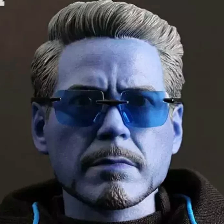



-------------------------------------------
GRADCAM Heat Map for Layer block5_conv1: 
-------------------------------------------



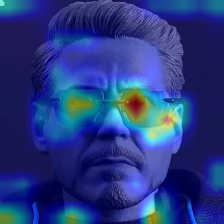



-------------------------------------------
GRADCAM Heat Map for Layer block5_conv2: 
-------------------------------------------



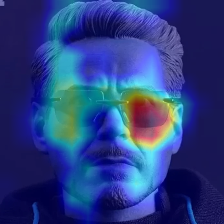



-------------------------------------------
GRADCAM Heat Map for Layer block5_conv3: 
-------------------------------------------



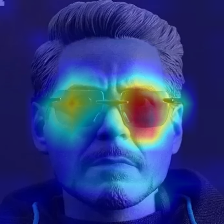

In [0]:
print("Original Image :\n---------------------------------\n")
cv2_imshow(tony_stark)

for laiyer in layers_list:
  grads = K.gradients(class_output, laiyer.output)[0]
  #print(grads.shape)
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  #print(pooled_grads.shape)
  iterate = K.function([model.input], [pooled_grads, laiyer.output[0]])

  pooled_grads_value, conv_layer_output_value = iterate([x])

  for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
    
  #Average the weighted feature map along the channel dimension resulting in a heat map of size 14x14  
  heatmap = np.mean(conv_layer_output_value, axis = -1)
  #print(conv_layer_output_value.shape)
  #print(heatmap.shape)
  
  
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  heatmap = cv2.resize(heatmap, (dog.shape[1], tony_stark.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(tony_stark, 0.5, heatmap, 0.5, 0)
  print("\n\n-------------------------------------------\nGRADCAM Heat Map for Layer "+laiyer.name+": \n-------------------------------------------\n")
  
  cv2_imshow(superimposed_img)  

### In the first part of this exercise we used Grad-CAM to see how various layers activate for a given class prediction and also used the heatmaps to 'find'/highlight sunglasses in an image



# Section 2 : 
### Receptive field calculation for example found in the paper titled [CNN-based Segmentation of Medical Imaging Data](https://arxiv.org/pdf/1701.03056.pdf)

We will try and arrive at the Receptive field of 45 mentioned in the following table from the paper 

![conv_layers](https://raw.githubusercontent.com/ravindrabharathi/eip3/master/images/conv_layers2.png)

As mentioned in the extract below, all the layers are 3x3 convolutions with zero-padding to ensure desired sizes of output and every contracting conv block has a 2 strided layer at the beginning which reduces the output size to half of the input size  

![conv_layers](https://raw.githubusercontent.com/ravindrabharathi/eip3/master/images/conv_layers1.png)


## RF Calculation to show how receptive field at 7 becomes 45 

>The formula for RF calculation is as shown below

> ![Effective RF calc](https://raw.githubusercontent.com/ravindrabharathi/eip3/master/images/rf_calc.png)




| Layer | Kernel size(k) | stride(s) |jump(j) | Effective Receptive Field |
| :--- | :---: | :---: | :---: | :---: | 
| Input            |     |    | 1  | 1   |
| 1.conv         |  3 | 1 | 1  | 3   |
| 2. conv /2   |  3 | 2 | 2  | 5  |
| 3. conv        |  3 | 1 | 2  | 9 |
| 4. conv /2   |  3 | 2 | 4  | 13 |
| 5. conv        |  3 | 1 | 4  | 21 | 
| 6. conv /2   |  3 | 2 | 8  | 29 |
| 7. conv        |  3 | 1 | 8 | 45 |
